In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.chdir("/home/mohsen/projects/scarches/")

In [2]:
import scanpy as sc
import numpy as np
import scarches as sca

Using TensorFlow backend.


In [3]:
sc.settings.set_figure_params(dpi=200)

In [4]:
condition_key = "condition"
cell_type_key = 'final_annotation'
target_conditions = ["10X"]
target_cell_types = ['NK cells', 'NKT cells']

In [5]:
sc.settings.figdir = "/home/mohsen/scarches_review_results/pbmc_ood/"

# Loading PBMC dataset

In [6]:
adata = sc.read("/home/mohsen/data/PBMC/Immune_ALL_human_wo_villani_normalized_hvg.h5ad")
adata

AnnData object with n_obs × n_vars = 32484 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [7]:
adata.X.min(), adata.X.max()

(0.0, 9.650221)

## Number of cells in each batch

In [8]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata = source_adata[~source_adata.obs[cell_type_key].isin(target_cell_types)]
source_adata

View of AnnData object with n_obs × n_vars = 18530 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [9]:
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
target_adata

View of AnnData object with n_obs × n_vars = 10727 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [10]:
source_conditions = source_adata.obs[condition_key].unique().tolist()
source_conditions

['Oetjen_A',
 'Oetjen_P',
 'Oetjen_U',
 'Freytag',
 'Sun_sample1_CS',
 'Sun_sample2_KC',
 'Sun_sample3_TB',
 'Sun_sample4_TC']

# Create & Train model with training data

In [11]:
network = sca.models.scArches(task_name='pbmc_ood_reference',
                              x_dimension=adata.shape[1], 
                              z_dimension=10,
                              architecture=[128, 128],
                              gene_names=adata.var_names.tolist(),
                              conditions=source_conditions,
                              lr=0.001,
                              alpha=0.00001,
                              eta=50.,
                              device='gpu',
                              use_batchnorm=True,
                              loss_fn='mse',
                              model_path="./models/CVAE/MSE/",
                              dropout_rate=0.1,
                              )









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

scArches' network has been successfully constructed!




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
scArches' network has been successfully compiled!


## Training the network

In [12]:
network.train(source_adata,
              train_size=0.9,
              condition_key=condition_key,
              n_epochs=300,
              batch_size=64,
              early_stop_limit=15,
              lr_reducer=10,
              save=True,
              retrain=False,
              )



scArches' network has been successfully compiled!
cvae's weights has been successfully restored!


In [13]:
latent_adata = network.get_latent(source_adata, condition_key)
latent_adata

AnnData object with n_obs × n_vars = 18530 × 10
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [14]:
sc.settings.figdir = '/home/mohsen/scarches_review_results/pbmc_ood_nk_nkt/'

In [15]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

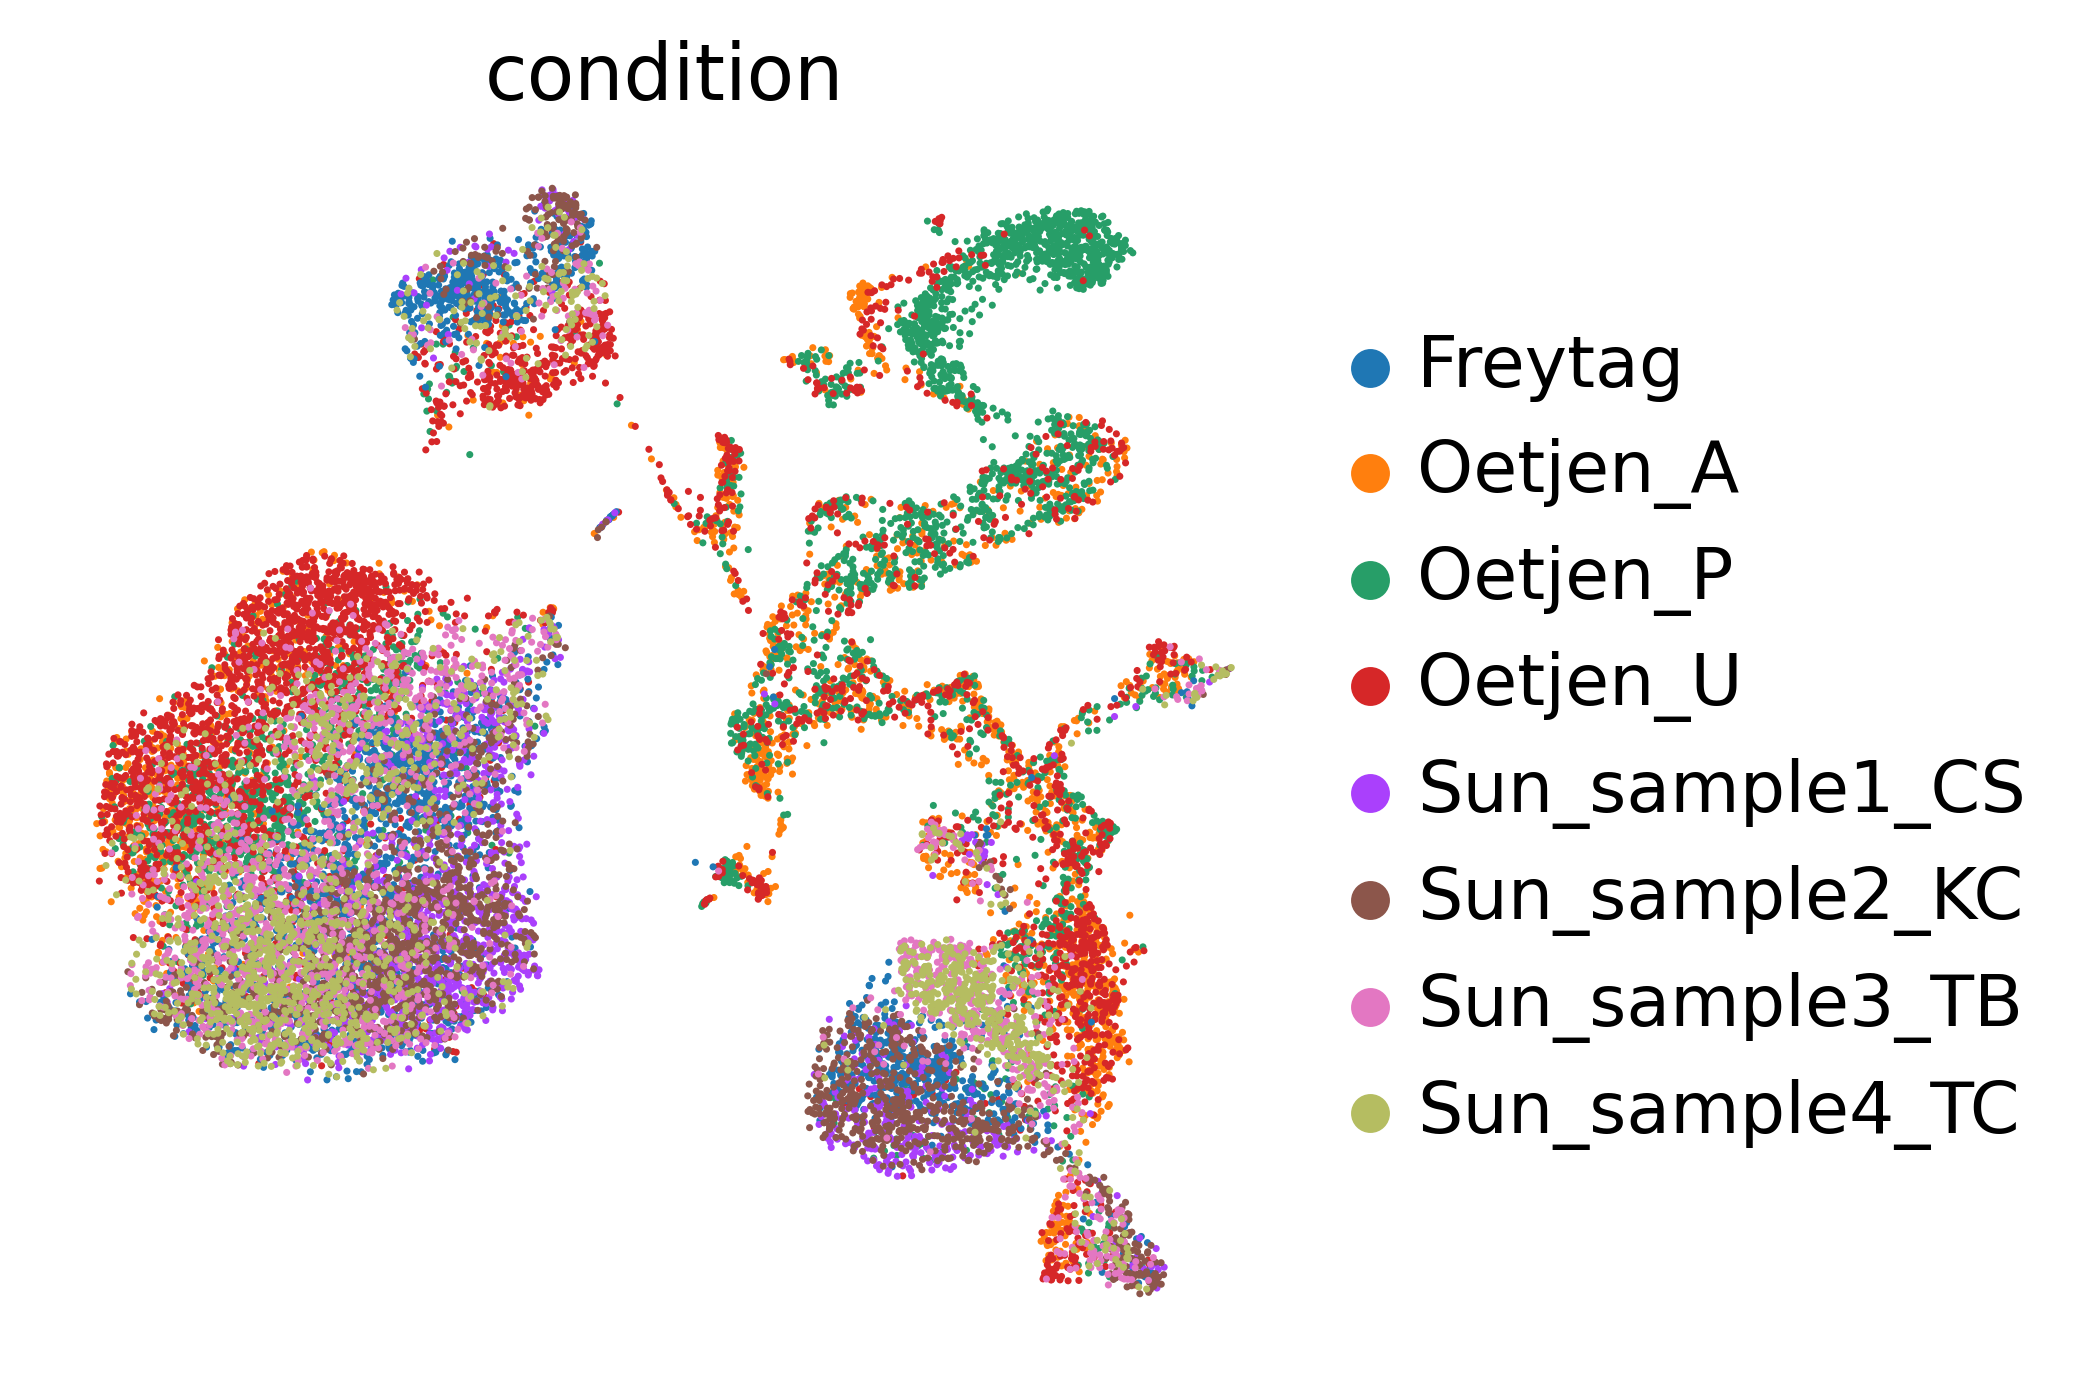

In [16]:
sc.pl.umap(latent_adata, color=[condition_key], 
           wspace=0.5, frameon=False)

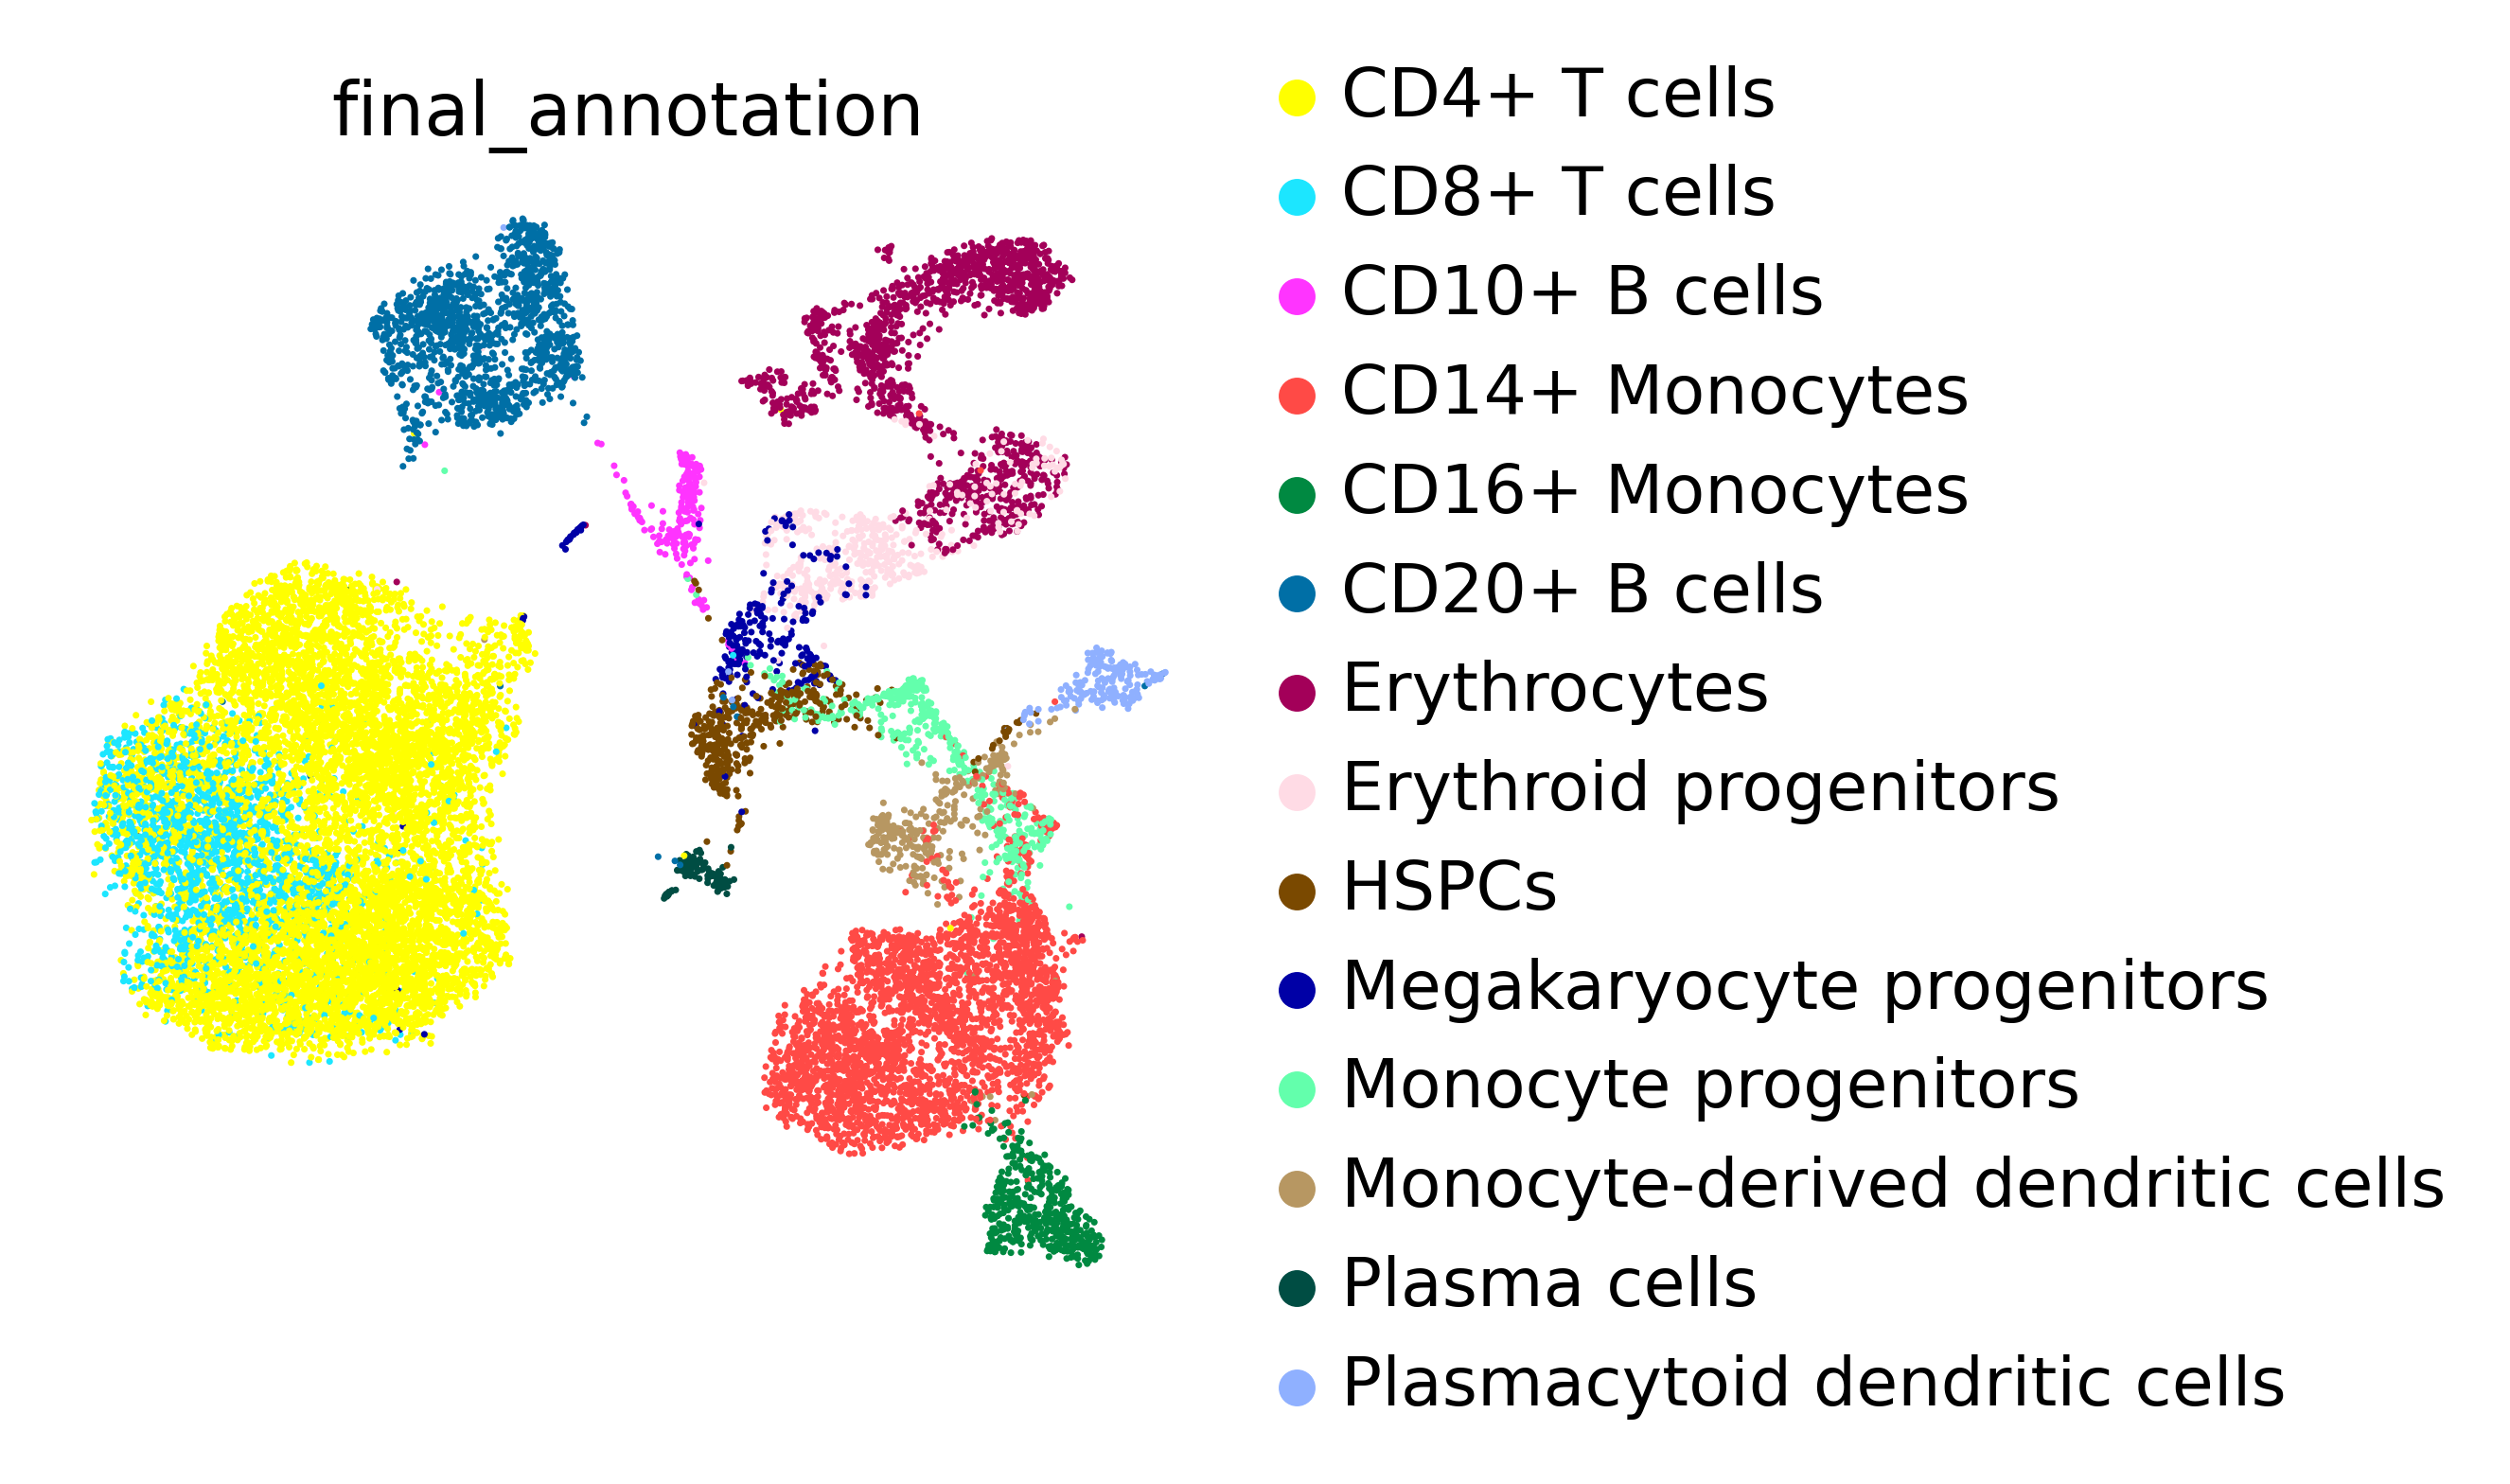

In [18]:
sc.pl.umap(latent_adata, color=[cell_type_key], palette=sc.pl.palettes.godsnot_102,
           wspace=0.5, frameon=False)

In [22]:
# palette = ['#023fa5', '#bec1d4','#bb7784']

In [23]:
# sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", 
#            save="_condition_before.pdf", palette=palette)

In [24]:
# palette = sc.pl.palettes.godsnot_102[:1] + sc.pl.palettes.godsnot_102[2:]

In [25]:
# sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", 
#            save="_cell_type_before.pdf", palette=palette)

# Perfroming architecture Surgery

In [19]:
new_network = sca.operate(network, 
                          new_task_name='pbmc_ood_nk_after',
                          new_conditions=target_conditions,
                          init='Xavier',
                          version='scArches',
                          remove_dropout=True,
                          print_summary=False,
                          )

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!
scArches' network has been successfully compiled!


In [20]:
new_network.condition_encoder

{'Freytag': 0,
 'Oetjen_A': 1,
 'Oetjen_P': 2,
 'Oetjen_U': 3,
 'Sun_sample1_CS': 4,
 'Sun_sample2_KC': 5,
 'Sun_sample3_TB': 6,
 'Sun_sample4_TC': 7,
 '10X': 8}

## Train with small new dataset containing out-of-sample condition

In [21]:
new_network.train(target_adata,
                  train_size=0.9, 
                  condition_key=condition_key,
                  n_epochs=150,
                  batch_size=64, 
                  early_stop_limit=15,
                  lr_reducer=10, 
                  save=True,
                  retrain=False)

scArches' network has been successfully compiled!
cvae's weights has been successfully restored!


In [32]:
# palette = ['#7d87b9', '#d6bcc0']

In [33]:
# sc.pl.umap(latent_adata_after, color=[condition_key], frameon=False, title="", 
#            save="_condition_out_of_sample_after.pdf", palette=palette)

In [34]:
# sc.pl.umap(latent_adata_after, color=[cell_type_key], frameon=False, title="", 
#            save="_cell_type_out_of_sample_after.pdf", palette=sc.pl.palettes.godsnot_102)

In [22]:
plot_adata = source_adata.concatenate(target_adata)
plot_adata

AnnData object with n_obs × n_vars = 29257 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [23]:
latent_adata = new_network.get_latent(plot_adata, condition_key)
latent_adata

AnnData object with n_obs × n_vars = 29257 × 10
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [24]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

... storing 'chemistry' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'condition' as categorical


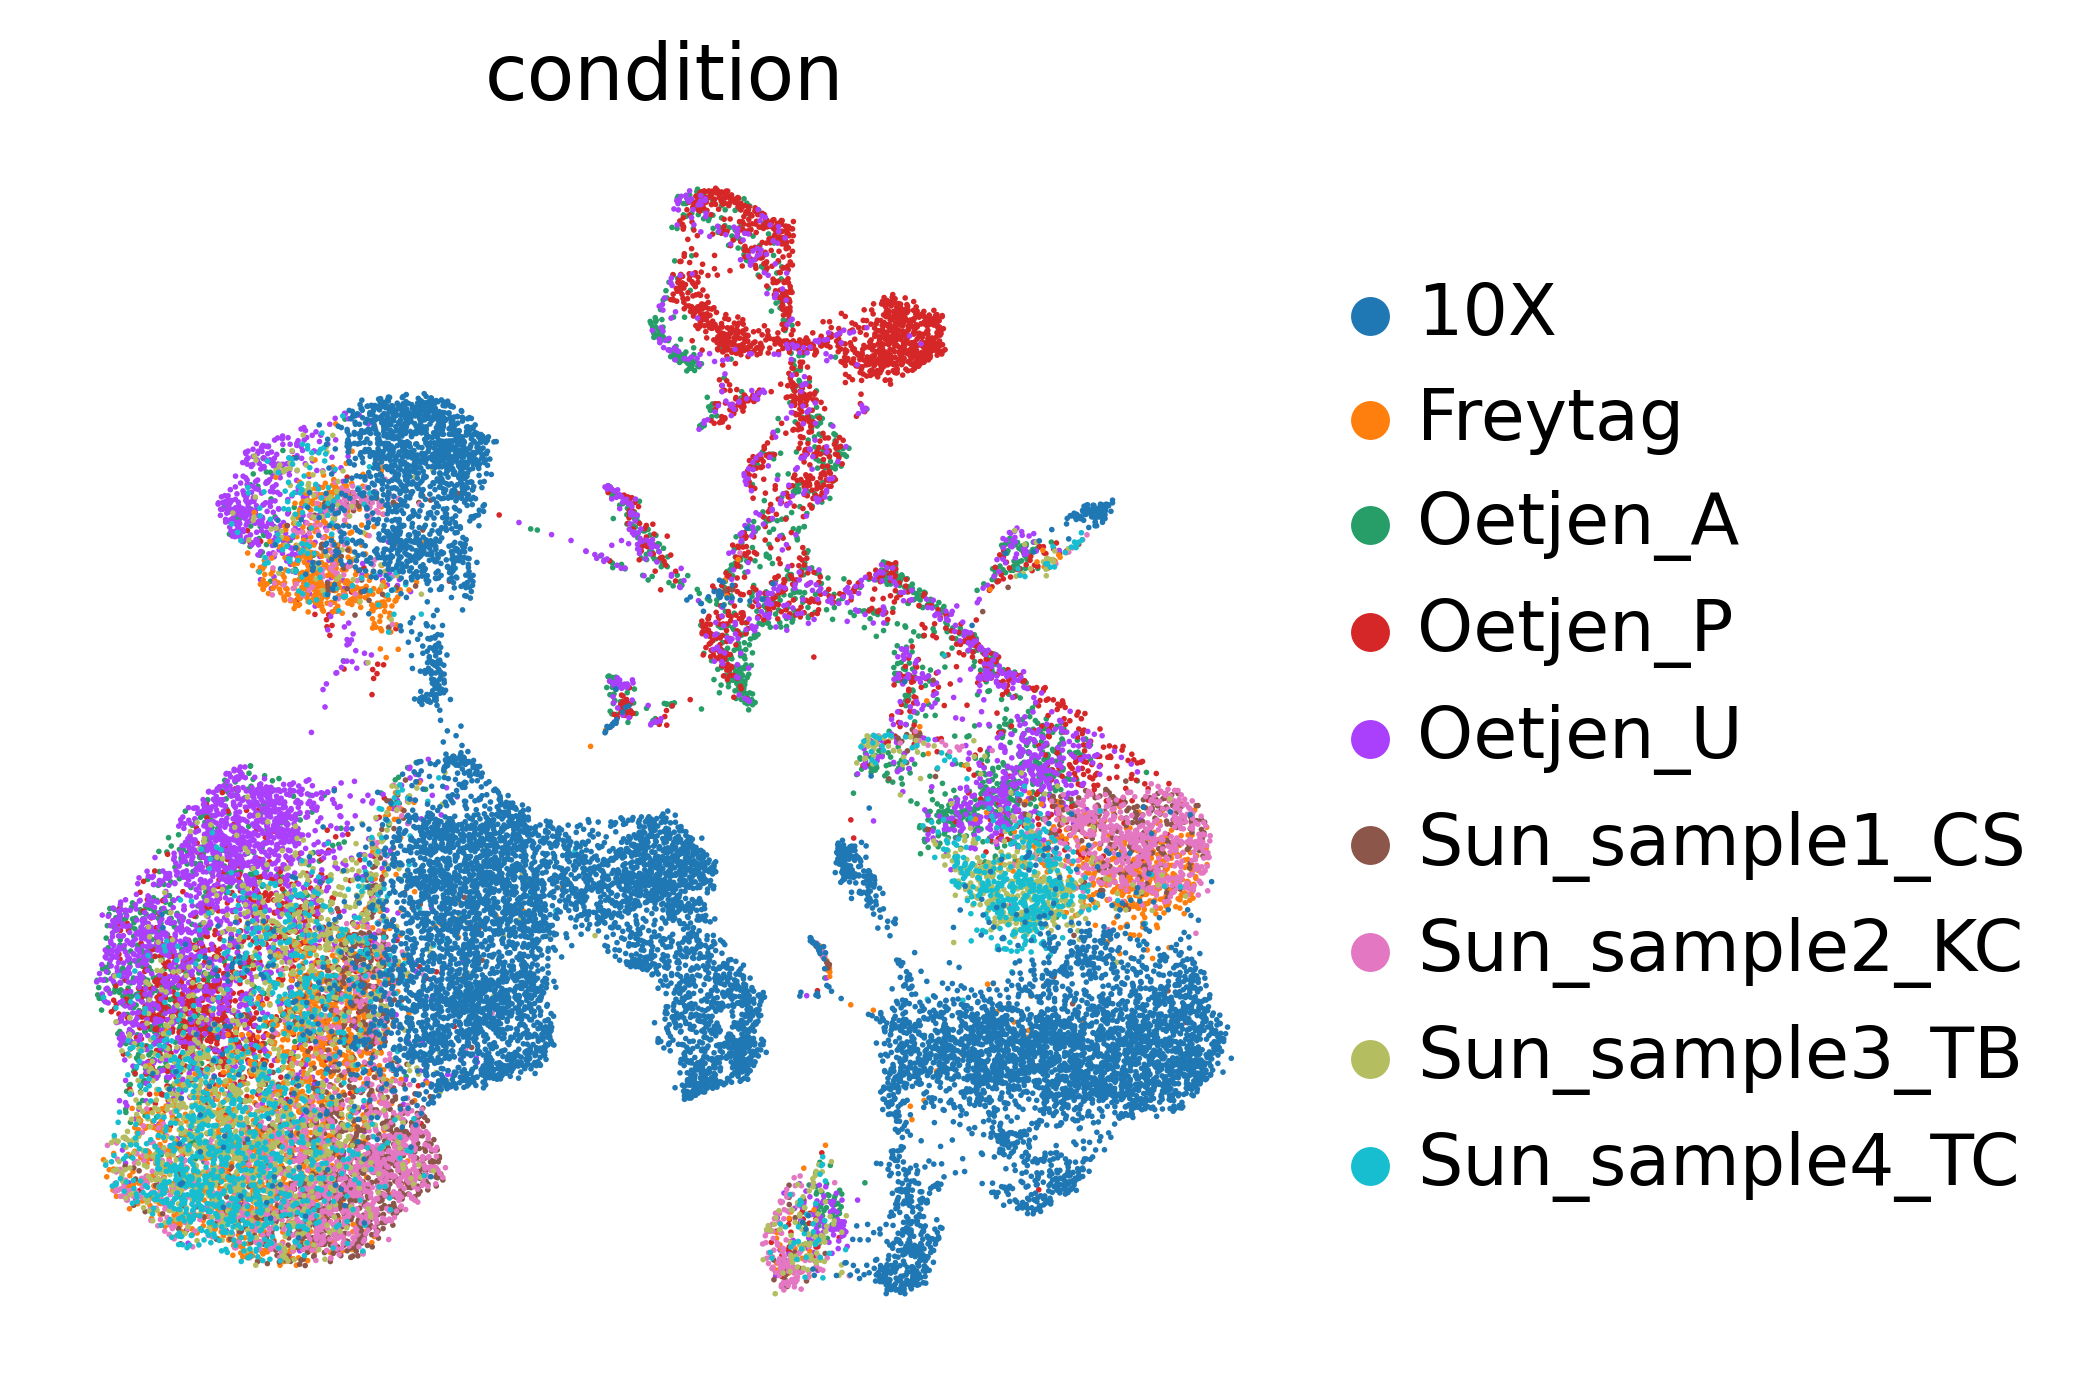

In [25]:
sc.pl.umap(latent_adata, color=[condition_key], 
           wspace=0.5, frameon=False, )

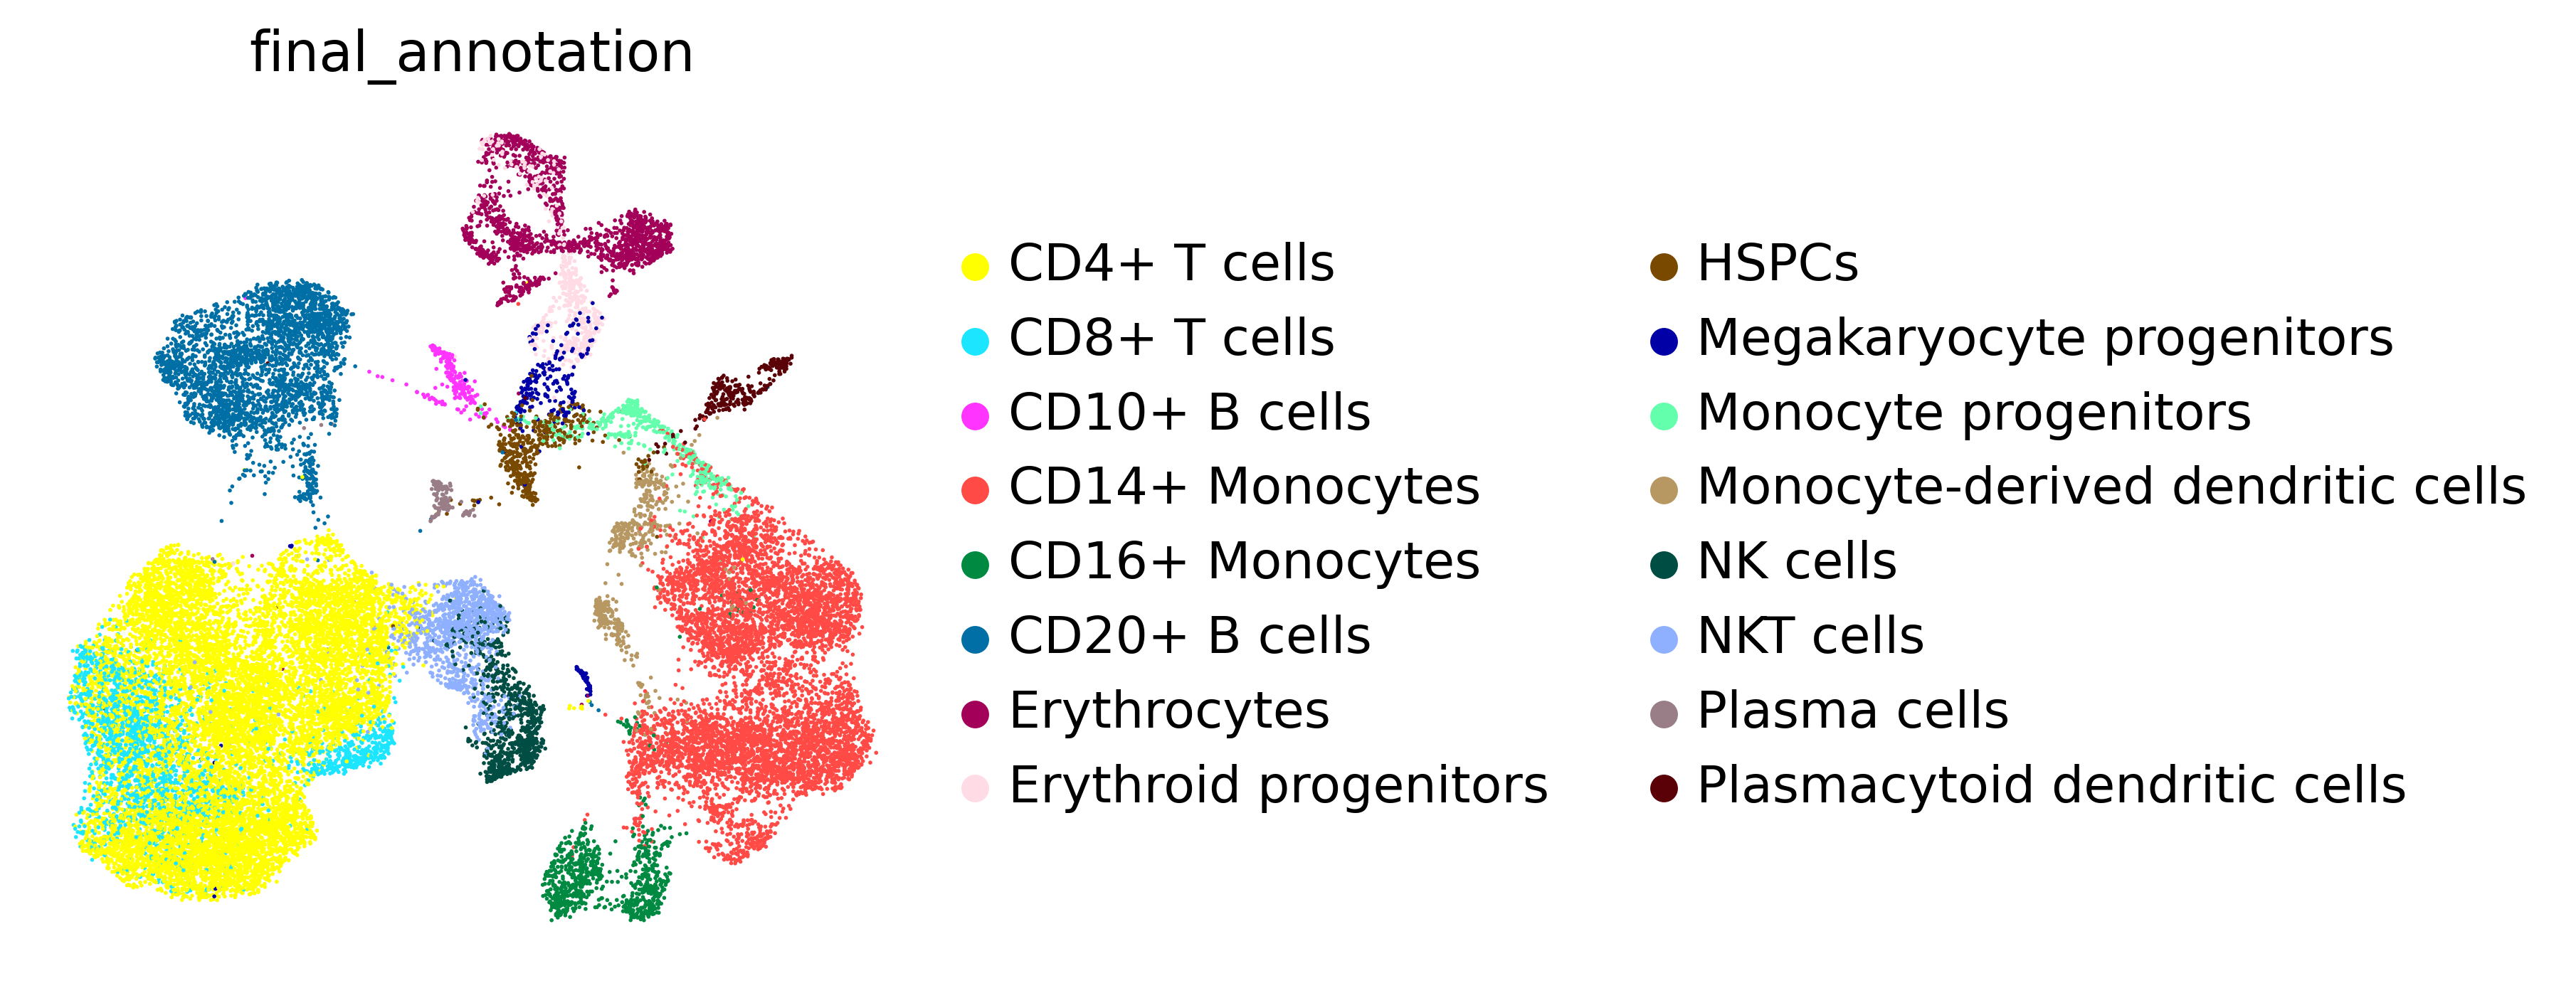

In [26]:
sc.pl.umap(latent_adata, color=[cell_type_key], palette=sc.pl.palettes.godsnot_102, 
           wspace=0.5, frameon=False, )

In [39]:
# palette = batch_colors

In [40]:
# sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", 
#            save="_condition_all_after.pdf", palette=palette)

In [41]:
# sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", 
#            save="_cell_type_all_after.pdf", palette=sc.pl.palettes.godsnot_102)